In [1]:
import json
import random
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import torch
import torchvision.transforms.functional as F
from torchvision.io import read_image

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [2]:
root = r"./data/Pascal VOC 2012/VOCdevkit/VOC2012"
val_txt_path = str(Path(root) / "ImageSets/Segmentation/val.txt")
with open(val_txt_path, "r", encoding="utf-8") as f:
    val_filename_list = f.read().splitlines()
random.shuffle(val_filename_list)
image_list = [read_image(str(Path(root) / "JPEGImages" / (str(filename) + ".jpg"))) for filename in val_filename_list]
target_list = [read_image(str(Path(root) / "SegmentationClass" / (str(filename) + ".png"))) for filename in
               val_filename_list]
len(val_filename_list), len(image_list)

(1449, 1449)

In [3]:
color_json_path = str(Path(root) / "ImageSets/Segmentation/palette.json")
with open(color_json_path, "r", encoding="utf-8") as f:
    color_dict = json.load(f)
len(color_dict)

256

In [4]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
# pytorch语义分割默认图像预处理：resize裁剪/插值->pil_to_tensor转张量->convert_image_dtype转浮点->normalize均值标准差归一化
transforms = weights.transforms(resize_size=None)
# 预训练时的类别，被保存在预训练权重weight里
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
num_classes = len(sem_class_to_idx)

# model = fcn_resnet50(weights=weights, progress=False)
model_random = fcn_resnet50(progress=False)
model_pretrain = fcn_resnet50(weights=weights, progress=False)
model_random = model_random.eval()
model_pretrain = model_pretrain.eval()

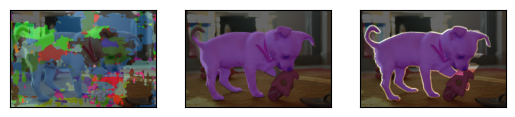

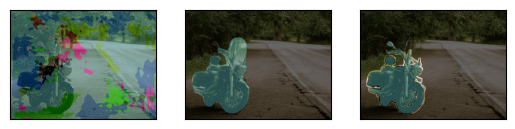

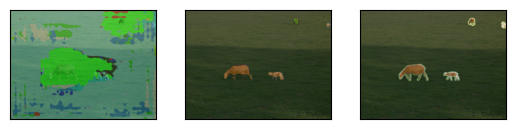

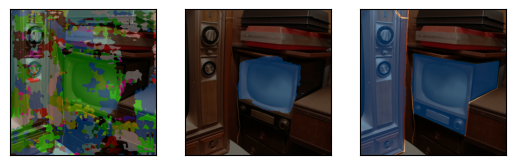

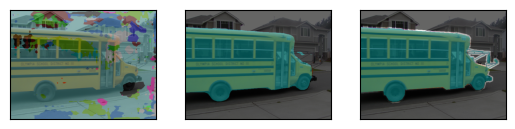

In [5]:
from torchvision.utils import draw_segmentation_masks

simple_num = 5  # 预测样本数量，通过切片实现

for i in range(simple_num):
    img = image_list[i]
    img_float = transforms(img).unsqueeze(0)
    # 对21种类别做了判断，所以有dim=1的长度为21
    out_img = torch.cat([model_random(img_float)['out'], model_pretrain(img_float)['out']], dim=0)
    # 对每个像素的预测结果维度归一化
    normalized_masks = out_img.softmax(dim=1)
    out_masks = normalized_masks.argmax(1) == torch.arange(num_classes)[:, None, None, None]
    out_masks = out_masks.swapaxes(0, 1)
    target_mask = target_list[i][0] == torch.arange(num_classes)[:, None, None]
    out_masks = torch.cat([out_masks, target_mask.unsqueeze(0)], dim=0)
    img_with_masks = [
        draw_segmentation_masks(img, masks=mask, alpha=.6, colors=[tuple(value) for value in color_dict.values()])
        for mask in out_masks
    ]
    show(img_with_masks)

In [7]:
# 预训练时的类别，被保存在预训练权重weight里
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

tvmonitor_background_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(image_list))
    for cls in ('tvmonitor', '__background__')
]

show(tvmonitor_background_masks)

NameError: name 'output' is not defined

shape = torch.Size([2, 375, 500]), dtype = torch.bool


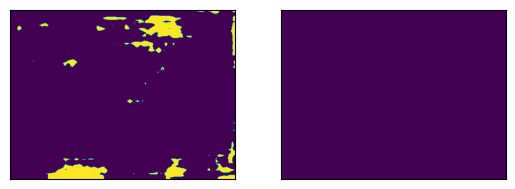

In [9]:
class_dim = 1
boolean_tvmonitor_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['tvmonitor'])
print(f"shape = {boolean_tvmonitor_masks.shape}, dtype = {boolean_tvmonitor_masks.dtype}")
show([m.float() for m in boolean_tvmonitor_masks])

In [10]:
from torchvision.utils import draw_segmentation_masks

tvmonitor_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7)
    for img, mask in zip(image_list, boolean_tvmonitor_masks)
]
show(tvmonitor_with_masks)

ValueError: The image and the masks must have the same height and width

In [11]:
num_classes = normalized_masks.shape[1]
img1_masks = normalized_masks[0]
class_dim = 0
img1_all_classes_masks = img1_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None]

print(f"img1_masks shape = {img1_masks.shape}, dtype = {img1_masks.dtype}")
print(f"img1_all_classes_masks = {img1_all_classes_masks.shape}, dtype = {img1_all_classes_masks.dtype}")

tvmonitor_with_all_masks = draw_segmentation_masks(img1, masks=img1_all_classes_masks, alpha=.6)
show(tvmonitor_with_all_masks)

img1_masks shape = torch.Size([21, 375, 500]), dtype = torch.float32
img1_all_classes_masks = torch.Size([21, 375, 500]), dtype = torch.bool


NameError: name 'img1' is not defined

In [12]:
class_dim = 1
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")
# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

tvmonitors_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6)
    for img, mask in zip(image_list, all_classes_masks)
]
show(tvmonitors_with_masks)

shape = torch.Size([21, 2, 375, 500]), dtype = torch.bool


ValueError: The image and the masks must have the same height and width